<a href="https://colab.research.google.com/github/Ash100/Supplementary_data_of_PARP1_Inhibitors/blob/main/Chemical_Space_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- Install dependencies ---
!pip install -q rdkit pandas scikit-learn matplotlib seaborn tqdm

# --- Import libraries ---
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, Lipinski, QED
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit import DataStructs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 51.8 MB/s eta 0:00:00


In [3]:
# --- Paths (edit to match your uploads in /content) ---
DATASET_PATH = '/content/coconut_csv-10-2025.csv'       # your 700k-compound CSV
FOUR_COMPOUNDS_PATH = '/content/dataset_4.csv'  # 4 compounds with identifier + canonical_smiles
OUTPUT_DIR = '/content/chem_analysis_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Helper functions ---
def mol_from_smiles(smiles):
    try:
        m = Chem.MolFromSmiles(smiles)
        if m:
            Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def compute_descriptors(mol):
    d = {
        'MolWt': Descriptors.MolWt(mol),
        'ExactMolWt': Descriptors.ExactMolWt(mol),
        'LogP': Crippen.MolLogP(mol),
        'TPSA': rdMolDescriptors.CalcTPSA(mol),
        'HBA': Lipinski.NumHAcceptors(mol),
        'HBD': Lipinski.NumHDonors(mol),
        'RotatableBonds': Lipinski.NumRotatableBonds(mol),
        'AromaticRings': rdMolDescriptors.CalcNumAromaticRings(mol),
        'NumRings': rdMolDescriptors.CalcNumRings(mol),
        'FractionCSP3': rdMolDescriptors.CalcFractionCSP3(mol),
        'FormalCharge': Chem.GetFormalCharge(mol)
    }
    try:
        d['QED'] = QED.qed(mol)
    except Exception:
        d['QED'] = np.nan
    return d

def fingerprint_bits(mol, nBits=2048, radius=2):
    return GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)


In [4]:
four = pd.read_csv(FOUR_COMPOUNDS_PATH)
smiles_col = [c for c in four.columns if c.lower() in ('canonical_smiles','smiles')][0]
four = four.rename(columns={smiles_col:'canonical_smiles'})

four['mol'] = four['canonical_smiles'].apply(mol_from_smiles)

rows = []
for _, r in four.iterrows():
    m = r['mol']
    if m:
        desc = compute_descriptors(m)
        desc['identifier'] = r.get('identifier','compound')
        desc['canonical_smiles'] = r['canonical_smiles']
        rows.append(desc)
four_desc = pd.DataFrame(rows)
four_desc.to_csv(f"{OUTPUT_DIR}/four_descriptors.csv", index=False)
four_desc.head()


,MolWt,ExactMolWt,LogP,TPSA,HBA,HBD,RotatableBonds,AromaticRings,NumRings,FractionCSP3,FormalCharge,QED,identifier,canonical_smiles
0,271.276,271.095691,1.80150,118.44,4,4,3,2,2,0.000000,0,0.634611,CNP0397780.0,NC1=CC=C(C(=O)NC2=CC=C(C(=O)O)C(N)=C2)C=C1
1,459.594,459.263425,2.87740,71.68,4,2,5,3,5,0.407407,0,0.615606,CNP0599203.1,CN1CCC(N2CCN(C(=O)[C@H](NC(=O)C3=CC=C4C=CNC4=C...
2,137.138,137.047678,1.08822,50.19,2,1,1,1,1,0.142857,0,0.629826,CNP0520053.0,CC1=CN=CC(C(=O)O)=C1
3,488.552,488.228437,2.78180,117.63,9,2,5,3,6,0.400000,0,0.558898,CNP0524774.1,O=C(NC1=CC=NC=C1)NC1=CC=C(C2=NC(N3CCOCC3)=NC(N...


In [8]:
four = pd.read_csv('/content/dataset_4.csv', comment='#', skip_blank_lines=True)
four = four.dropna(subset=['canonical_smiles']).reset_index(drop=True)


In [9]:
display(four)
print("Number of valid rows:", len(four))


,identifier,canonical_smiles,standard_inchi,standard_inchi_key,name,iupac_name,annotation_level,total_atom_count,heavy_atom_count,molecular_weight,...,direct_parent_classification,np_classifier_pathway,np_classifier_superclass,np_classifier_class,np_classifier_is_glycoside,organisms,collections,dois,synonyms,cas
0,CNP0397780.0,NC1=CC=C(C(=O)NC2=CC=C(C(=O)O)C(N)=C2)C=C1,InChI=1S/C14H13N3O3/c15-9-3-1-8(2-4-9)13(18)17...,GGUOSFAJMKBDFW-UHFFFAOYSA-N,Carotamine,2-amino-4-[(4-aminobenzoyl)amino]benzoic acid,3.0,33.0,20.0,271.28,...,Benzanilides,Amino acids and Peptides,Small peptides,Aminoacids,False,Daucus carota,FooDB|Super Natural II|UNPD (Universal Natural...,10.3390/70600501,CHEBI:191847|2-Amino-4-(4-aminobenzoylamino)be...,NaN
1,CNP0599203.1,CN1CCC(N2CCN(C(=O)[C@H](NC(=O)C3=CC=C4C=CNC4=C...,InChI=1S/C27H33N5O2/c1-30-13-10-23(11-14-30)31...,VYNKVNDKAOGAAQ-RUZDIDTESA-N,313489-71-3,~{N}-[(1~{R})-2-[4-(1-methyl-4-piperidyl)piper...,2.0,67.0,34.0,459.59,...,N-acyl-alpha amino acids,Alkaloids,NaN,NaN,False,NaN,DrugBankNP,NaN,LY 517717|LY-517717|UNII-TSA990HP1K|TSA990HP1K...,NaN
2,CNP0520053.0,CC1=CN=CC(C(=O)O)=C1,InChI=1S/C7H7NO2/c1-5-2-6(7(9)10)4-8-3-5/h2-4H...,DJDHHXDFKSLEQY-UHFFFAOYSA-N,5-Methylnicotinic acid,5-methylpyridine-3-carboxylic acid,2.0,17.0,10.0,137.14,...,Pyridine-3-carboxylic acids,Alkaloids,Nicotinic acid alkaloids,Pyridine alkaloids,False,NaN,Supernatural3,NaN,3222-49-9|5-methylpyridine-3-carboxylic acid|5...,NaN
3,CNP0524774.1,O=C(NC1=CC=NC=C1)NC1=CC=C(C2=NC(N3CCOCC3)=NC(N...,InChI=1S/C25H28N8O3/c34-25(28-19-7-9-26-10-8-1...,WXUUCRLKXQMWRY-OYRHEFFESA-N,CNN7Y60164,"1-[4-[4-morpholino-6-[(1~{R},5~{S})-3-oxa-8-az...",2.0,64.0,36.0,488.55,...,N-phenylureas,Alkaloids,Nicotinic acid alkaloids,Pyridine alkaloids,False,NaN,DrugBankNP,NaN,PI 3-k\/mtorinhibitor III|UNII-CNN7Y60164|N-(4...,NaN


Number of valid rows: 4


In [10]:
from rdkit import DataStructs

four['mol'] = four['canonical_smiles'].apply(mol_from_smiles)
fps = [fingerprint_bits(m) for m in four['mol']]
pairwise = np.zeros((len(fps), len(fps)))

for i in range(len(fps)):
    for j in range(len(fps)):
        pairwise[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

pair_df = pd.DataFrame(
    pairwise,
    index=four['identifier'],
    columns=four['identifier']
)
pair_df.to_csv(f"{OUTPUT_DIR}/tanimoto_similarity_fixed.csv", index=True)
display(pair_df)


[13:27:49] DEPRECATION WARNING: please use MorganGenerator
[13:27:49] DEPRECATION WARNING: please use MorganGenerator
[13:27:49] DEPRECATION WARNING: please use MorganGenerator
[13:27:49] DEPRECATION WARNING: please use MorganGenerator


identifier,CNP0397780.0,CNP0599203.1,CNP0520053.0,CNP0524774.1
identifier,,,,
CNP0397780.0,1.000000,0.173333,0.200000,0.150685
CNP0599203.1,0.173333,1.000000,0.130435,0.173913
CNP0520053.0,0.200000,0.130435,1.000000,0.121212
CNP0524774.1,0.150685,0.173913,0.121212,1.000000


In [17]:
DS = pd.read_csv(DATASET_PATH, low_memory=False)
SAMPLE_N = 100000
sample = DS.sample(n=min(SAMPLE_N, len(DS)), random_state=42)

# detect SMILES column automatically
smiles_col = [c for c in sample.columns if 'smiles' in c.lower()][0]
rows = []
for s in tqdm(sample[smiles_col].astype(str).fillna('')):
    mol = mol_from_smiles(s)
    rows.append(compute_descriptors(mol) if mol else {k:np.nan for k in ['MolWt','LogP','TPSA','HBA','HBD','RotatableBonds','AromaticRings','FractionCSP3','QED']})
sample_desc = pd.DataFrame(rows).dropna(how='all')
sample_desc.to_csv(f"{OUTPUT_DIR}/sample_descriptors.csv", index=False)
sample_desc.head()


 11%|█         | 10706/100000 [00:40<05:04, 293.24it/s][13:45:44] SMILES Parse Error: syntax error while parsing: ANPDB|Australian
[13:45:44] SMILES Parse Error: check for mistakes around position 1:
[13:45:44] ANPDB|Australian
[13:45:44] ^
[13:45:44] SMILES Parse Error: Failed parsing SMILES 'ANPDB|Australian' for input: 'ANPDB|Australian'
 40%|███▉      | 39550/100000 [02:26<03:19, 303.73it/s][13:47:30] SMILES Parse Error: syntax error while parsing: nan
[13:47:30] SMILES Parse Error: check for mistakes around position 2:
[13:47:30] nan
[13:47:30] ~^
[13:47:30] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
 56%|█████▌    | 56039/100000 [03:26<04:06, 178.25it/s][13:48:30] SMILES Parse Error: syntax error while parsing: nan
[13:48:30] SMILES Parse Error: check for mistakes around position 2:
[13:48:30] nan
[13:48:30] ~^
[13:48:30] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
 57%|█████▋    | 57488/100000 [03:31<02:24, 294.03it/s][13:48:36] SMILES 

,MolWt,ExactMolWt,LogP,TPSA,HBA,HBD,RotatableBonds,AromaticRings,NumRings,FractionCSP3,FormalCharge,QED
0,961.636,960.908492,20.43140,78.90,6.0,0.0,56.0,0.0,0.0,0.951613,0.0,0.034327
1,353.853,353.129490,4.68792,42.16,4.0,0.0,4.0,3.0,4.0,0.300000,0.0,0.682114
2,694.758,694.297036,1.21492,203.52,12.0,6.0,12.0,2.0,7.0,0.555556,1.0,0.105935
3,328.412,328.178693,3.34800,64.36,4.0,1.0,5.0,2.0,3.0,0.473684,0.0,0.914005
4,328.276,328.058303,1.68380,109.36,7.0,3.0,0.0,3.0,5.0,0.235294,0.0,0.538641


/tmp/ipython-input-3035524312.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined[c].fillna(combined[c].median(), inplace=True)


✅ Figure saved at 600 dpi: /content/chem_analysis_outputs/chemical_space_PCA_pub.png


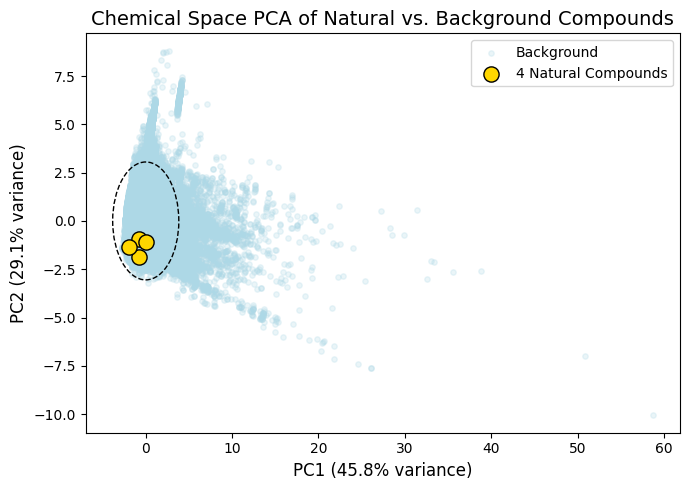

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

# --- PCA columns ---
pca_cols = ['MolWt','LogP','TPSA','HBA','HBD','RotatableBonds','AromaticRings','FractionCSP3']

# --- Combine data ---
combined = pd.concat([
    sample_desc[pca_cols].assign(source='Background'),
    four_desc[pca_cols].assign(source='Natural Compounds')
], ignore_index=True)

# --- Fill missing values ---
for c in pca_cols:
    combined[c].fillna(combined[c].median(), inplace=True)

# --- Scale & PCA ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined[pca_cols])

pca = PCA(n_components=2)
Xp = pca.fit_transform(X_scaled)
combined['PC1'], combined['PC2'] = Xp[:,0], Xp[:,1]

# --- Plot ---
plt.figure(figsize=(7,5))  # slightly smaller figure
plt.rcParams['font.family'] = 'Times New Roman'

# Background points: light blue
bg = combined[combined['source']=='Background']
plt.scatter(bg['PC1'], bg['PC2'], s=15, alpha=0.25, color='lightblue', label='Background')

# 95% confidence ellipse for background (black)
def confidence_ellipse(x, y, ax, n_std=2.0, **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be same size")
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse((mean_x, mean_y), width, height, angle=theta, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

ax = plt.gca()
confidence_ellipse(bg['PC1'].values, bg['PC2'].values, ax, n_std=2.0,
                   edgecolor='black', facecolor='none', linestyle='--', linewidth=1)

# Natural compounds: smaller golden circles
nc = combined[combined['source']=='Natural Compounds']
plt.scatter(nc['PC1'], nc['PC2'], s=120, color='gold', edgecolor='black', marker='o',
            label='4 Natural Compounds', zorder=5)

# Labels & legend
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)", fontsize=12)
plt.title("Chemical Space PCA of Natural vs. Background Compounds", fontsize=14)
plt.legend(loc='upper right', frameon=True, fontsize=10)
plt.grid(False)  # remove grid lines

plt.tight_layout()

# --- Save high-resolution figure ---
output_file = f"{OUTPUT_DIR}/chemical_space_PCA_pub.png"
plt.savefig(output_file, dpi=600)
print(f"✅ Figure saved at 600 dpi: {output_file}")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Descriptors to plot ---
des = ['MolWt','LogP','TPSA','HBA','HBD','RotatableBonds','FractionCSP3']

# Min-max normalization using background sample
mins, maxs = sample_desc[des].min(), sample_desc[des].max()

# Copy 4 compounds data and normalize
radar = four_desc.copy()
for c in des:
    radar[c+'_norm'] = (radar[c]-mins[c])/(maxs[c]-mins[c])

# Prepare radar angles
angles = np.linspace(0, 2*np.pi, len(des), endpoint=False).tolist()
angles += angles[:1]  # close the loop

# --- Plot ---
plt.figure(figsize=(8,8))
ax = plt.subplot(polar=True)
plt.rcParams['font.family'] = 'Times New Roman'

for _, r in radar.iterrows():
    vals = r[[c+'_norm' for c in des]].tolist()
    vals += vals[:1]  # close the loop
    ax.plot(angles, vals, linewidth=2, label=r['identifier'])
    ax.fill(angles, vals, alpha=0.15)

# Theta labels
ax.set_thetagrids(np.degrees(angles[:-1]), des)

# Range and legend
ax.set_ylim(0,1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2,1.05))
ax.set_title('Normalized Descriptor Radar — 4 Natural Compounds', y=1.08)

plt.tight_layout()
# Save high-res figure
plt.savefig(f"{OUTPUT_DIR}/radar_4compounds.png", dpi=600, bbox_inches='tight')
plt.show()


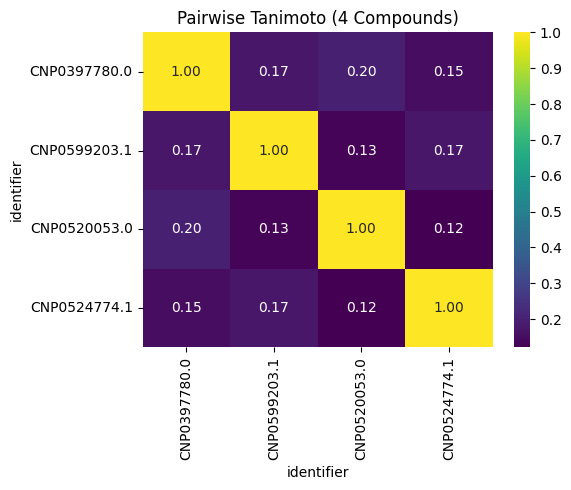

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(pair_df, annot=True, fmt='.2f', cmap='viridis')
plt.title('Pairwise Tanimoto (4 Compounds)')
plt.tight_layout()

# Save high-resolution figure
plt.savefig(f"{OUTPUT_DIR}/tanimoto_heatmap_4.png", dpi=600)
plt.show()


In [ ]:
four_desc.to_csv(f\"{OUTPUT_DIR}/four_descriptor_table_for_manuscript.csv\", index=False)
combined[['PC1','PC2','source']].to_csv(f\"{OUTPUT_DIR}/combined_pca_coordinates.csv\", index=False)
print(\"All files saved in:\", OUTPUT_DIR)
